In [140]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [141]:
import os
os.chdir('/content')  # Reset to base directory
!git clone https://github.com/chang-yue/dln.git
%cd dln


fatal: destination path 'dln' already exists and is not an empty directory.
/content/dln


In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from data.data_utils import *
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [143]:

df=pd.read_csv("/content/drive/MyDrive/ECE477/ECE477 Final Project/ECE477 Final Project Data/Final_ECE477_data_table.csv")
dtype_dict = df.dtypes.to_dict()
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.head())

   Catch_angle  Finish_angle  Length  Catch_slip  Finish_slip  Watts  Rating  \
0         57.6          32.7    90.3         7.1          8.5  284.0      28   
1         58.0          32.4    90.4         9.5          8.1  303.0      30   
2         57.8          32.6    90.4         9.4          8.6  301.0      30   
3         57.5          32.5    90.0         8.8          8.6  300.0      30   
4         56.8          31.5    88.3         7.8          6.0  263.0      28   

   Piece_length  Varsity?  
0          2000         0  
1          1000         0  
2          1000         0  
3          1000         0  
4          2000         0  


ADD TUTOR TO CREATE EXTRA DATA

In [144]:
df.rename(columns={"Varsity?":"Target"}, inplace=True)

# Shuffle and split data into train/(val)/test
seed = 5

train_fraction = 0.75 ###




df_train, df_temp = shuffle_split_data(df, train_fraction, seed=seed)
df_val, df_test = shuffle_split_data(df_temp, 0.5, seed=seed)

print('train:', df_train.shape)
print(np.unique(df_train.Target, return_counts=True))
print('\ntest:', df_test.shape)
print(np.unique(df_test.Target, return_counts=True))

train: (333, 9)
(array([0, 1]), array([240,  93]))

test: (56, 9)
(array([0, 1]), array([40, 16]))


ADD TUTOR

In [145]:
from sklearn.neighbors import KernelDensity
import numpy as np

def KDE_sample_generation(X_train, X_validation):
    bw_list = [2.1, 2.2,2.25,2.3, 2.35]
    log_like = np.zeros(len(bw_list))

    for i, bw in enumerate(bw_list):
        print(f"bw = {bw}")
        kde = KernelDensity(kernel='gaussian', bandwidth=bw)
        kde.fit(X_train)
        log_like[i] = kde.score(X_validation)
        print(f"log_like = {log_like[i]}")

    bbw = bw_list[np.argmax(log_like)]
    print(f"Best Bandwidth: {bbw}")

    kde = KernelDensity(kernel='gaussian', bandwidth=bbw)
    kde.fit(X_train)

    X_syn = kde.sample(2000)
    print(f"X_syn.shape: {X_syn.shape}")

    # Binary categorical column assumed to be the last column
    for i in range(X_syn.shape[0]):
        X_syn[i, -1] = 1 if X_syn[i, -1] >= 0.5 else 0  # Thresholding

    return X_syn


In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def semantic_integrity_classifier(X_syn, X_train, X_validation):
    X_train_total = np.concatenate((X_train, X_validation))
    continuous_indices = np.arange(X_train.shape[1] - 1)

    label_train = X_train[:, -1].astype(int)
    label_validation = X_validation[:, -1].astype(int)
    label_total = X_train_total[:, -1].astype(int)

    # Try multiple max_depths
    depth_list = [8, 9,10,11, 12, None]
    best_val_acc = -1
    best_depth = None
    best_clf = None

    for depth in depth_list:
        clf = RandomForestClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train[:, continuous_indices], label_train)

        y_pred_val = clf.predict(X_validation[:, continuous_indices])
        val_acc = accuracy_score(label_validation, y_pred_val)
        print(f"Validation accuracy (depth={depth}): {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_depth = depth
            best_clf = clf

    print(f"Best max_depth: {best_depth} with val accuracy: {best_val_acc:.4f}")

    # Re-train on full data with best depth
    final_clf = RandomForestClassifier(max_depth=best_depth, random_state=42)
    final_clf.fit(X_train_total[:, continuous_indices], label_total)

    # Semantic filtering
    X_syn_final = []
    for i in range(X_syn.shape[0]):
        pred = final_clf.predict(X_syn[i, continuous_indices].reshape(1, -1))[0]
        actual = int(X_syn[i, -1])
        if pred == actual:
            X_syn[i, -1] = pred  # Clean float values
            X_syn_final.append(X_syn[i])

    X_syn_final = np.array(X_syn_final)
    print("Shape of final X_syn:", X_syn_final.shape)

    return X_syn_final


In [147]:
X_syn = KDE_sample_generation(df_train, df_val)
X_syn = semantic_integrity_classifier(X_syn, np.array(df_train), np.array(df_val))

bw = 2.1
log_like = -1426.1364721445277
bw = 2.2
log_like = -1423.214438831129
bw = 2.25
log_like = -1422.5578634078347
bw = 2.3
log_like = -1422.360874227148
bw = 2.35
log_like = -1422.5743393446794
Best Bandwidth: 2.3
X_syn.shape: (2000, 9)
Validation accuracy (depth=8): 0.9107
Validation accuracy (depth=9): 0.9107
Validation accuracy (depth=10): 0.9107
Validation accuracy (depth=11): 0.9286
Validation accuracy (depth=12): 0.9286
Validation accuracy (depth=None): 0.9107
Best max_depth: 11 with val accuracy: 0.9286
Shape of final X_syn: (1082, 9)


In [148]:
varsity_indices = X_syn[:, -1] == 1
non_varsity_indices = X_syn[:, -1] == 0


print(varsity_indices.sum())
print(non_varsity_indices.sum())



232
850


In [149]:
import numpy as np
import pandas as pd

# Convert your training data and synthetic array to NumPy (if needed)
X_real = np.array(df_train)

# Step 1: Check real class distribution
real_counts = np.bincount(X_real[:, -1].astype(int))
print(f"Real data class counts: {real_counts}")

# Step 2: Split synthetic samples by class
syn_class_0 = X_syn[X_syn[:, -1] == 0]
syn_class_1 = X_syn[X_syn[:, -1] == 1]

# Step 3: Determine minority class and how many to sample
minority_class = 0 if real_counts[0] < real_counts[1] else 1
majority_class = 1 - minority_class
n_to_add = real_counts[majority_class] - real_counts[minority_class]

print(f"Adding {n_to_add} synthetic samples from class {minority_class}")

# Step 4: Select synthetic samples for balancing
syn_to_add = syn_class_0 if minority_class == 0 else syn_class_1
syn_to_add = syn_to_add[:n_to_add]  # take only what’s needed

# Step 5: Combine with real data
X_balanced = np.vstack([X_real, syn_to_add])
df_train = pd.DataFrame(X_balanced, columns=df_train.columns)


Real data class counts: [240  93]
Adding 147 synthetic samples from class 1


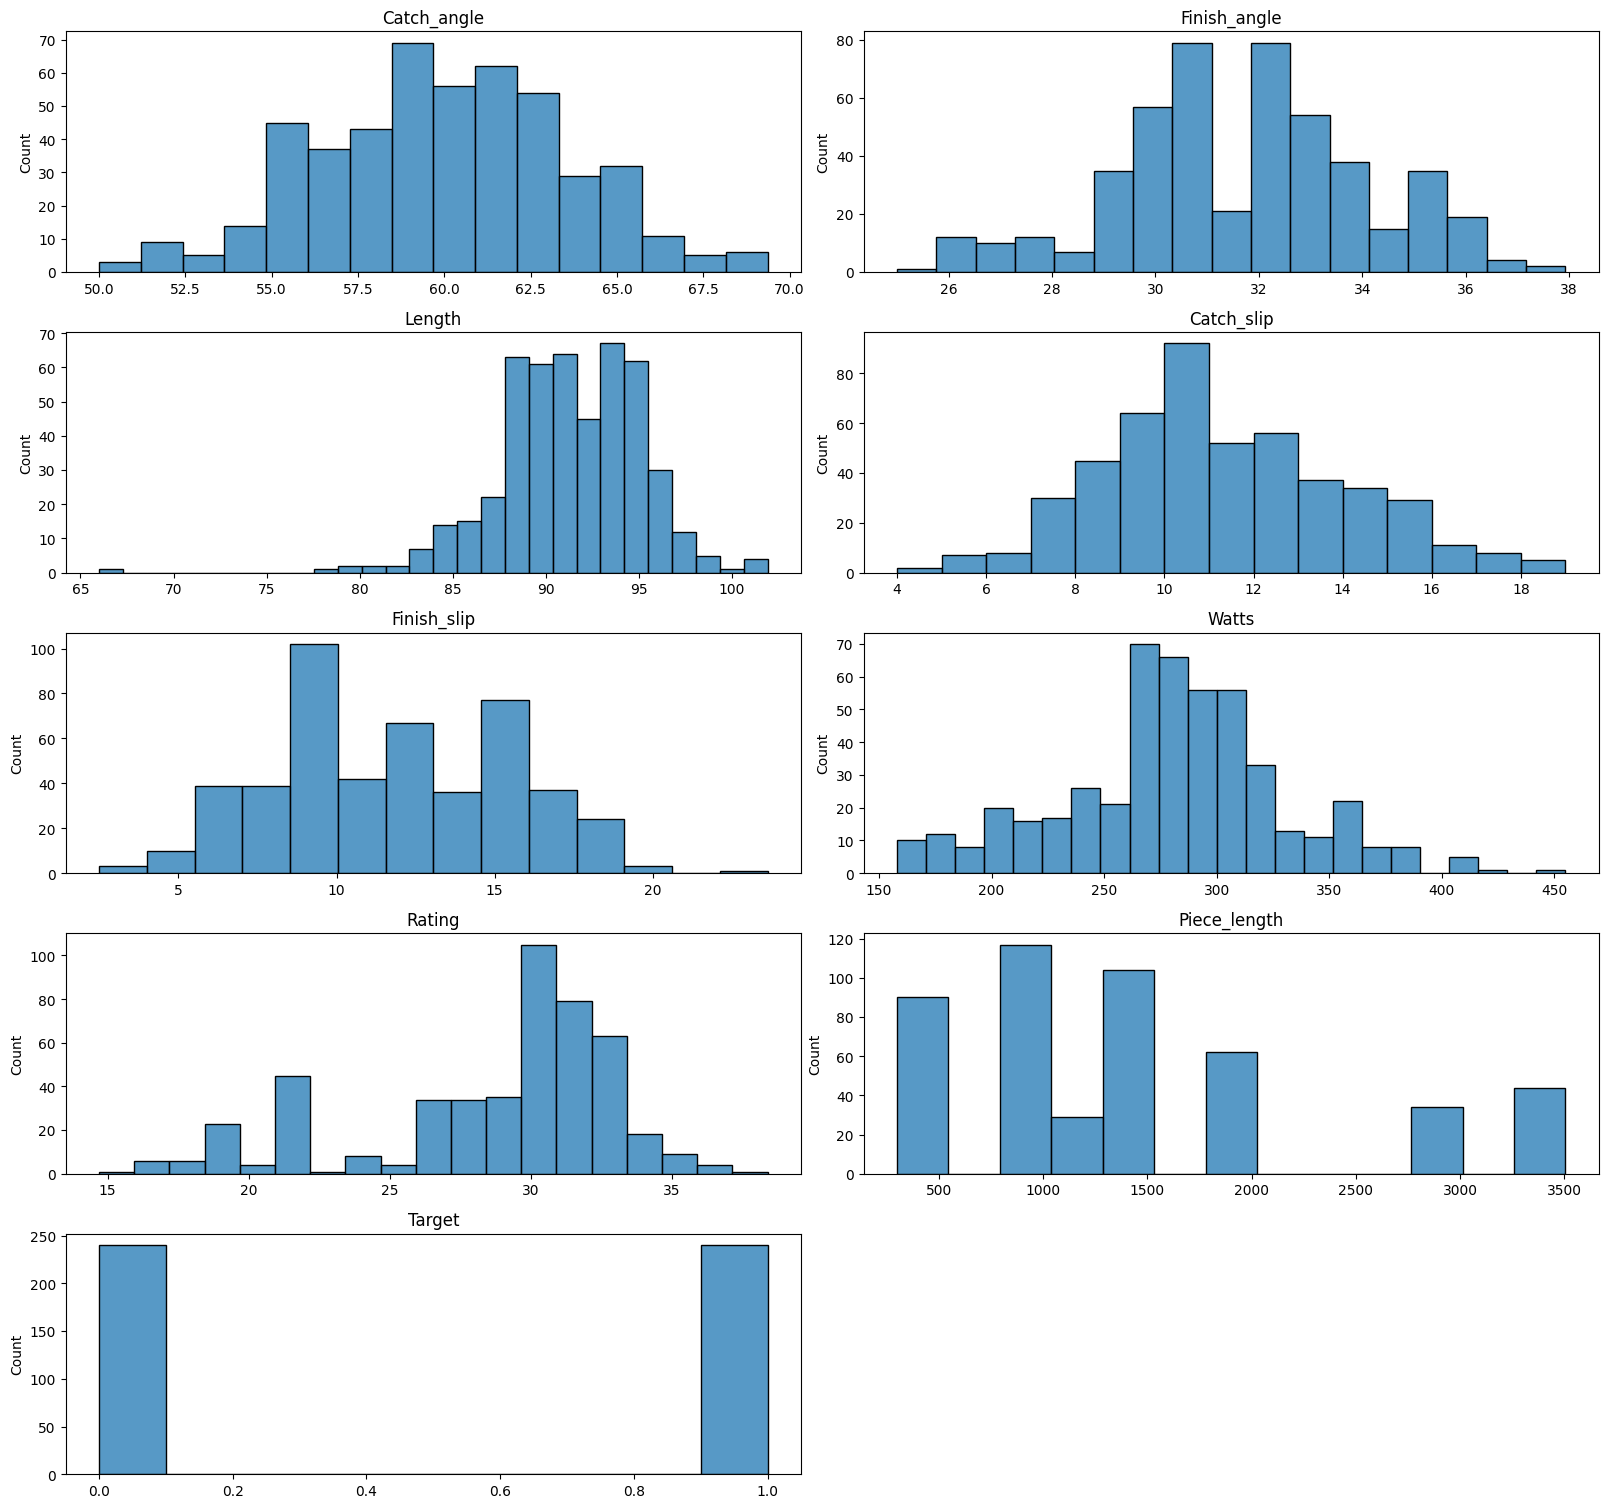

In [150]:
ncol, nrow = 2, int(np.ceil(len(df_train.columns)/2))
figsize = (16,3*nrow)

plot_hist(df_train, figsize, nrow, ncol)

Clip outliers, scale features, and then save the processed data and info

In [151]:

continuous_features = ['Catch_angle','Finish_angle','Length','Catch_slip','Finish_slip','Watts','Rating','Piece_length']
categorical_features = []
scaler_list = [MinMaxScaler(clip=True)]
feature_list = [continuous_features]


df_train_scaled, df_test_scaled, scaler_params = scale_features(df_train, df_test, feature_list, scaler_list)

In [152]:
print(df_train_scaled.head(10))

   Catch_angle  Finish_angle    Length  Catch_slip  Finish_slip     Watts  \
0     0.361554      0.463949  0.612530    0.266667     0.213363  0.367003   
1     0.309904      0.695923  0.668214    0.333333     0.355311  0.693603   
2     0.568157      0.463949  0.723899    0.466667     0.355311  0.407407   
3     0.516506      0.541274  0.723899    0.400000     0.544576  0.383838   
4     0.568157      0.386624  0.696057    0.533333     0.591892  0.316498   
5     0.413205      0.386624  0.612530    0.200000     0.544576  0.377104   
6     0.723108      0.463949  0.807426    0.200000     0.639208  0.175084   
7     0.619807      0.154650  0.640372    0.400000     0.733840  0.212121   
8     0.516506      0.541274  0.723899    0.266667     0.591892  0.683502   
9     0.413205      0.541274  0.668214    0.466667     0.497260  0.367003   

     Rating  Piece_length  Target  
0  0.308270      0.998253     1.0  
1  0.772416      0.000589     0.0  
2  0.645830      0.218828     1.0  
3  0.645

In [153]:
# Save the processed data and feature information

# Save data into the data/datasets/Rowing/seed_0/data directory
# scaler_params and dtype_dict are used for network visualization
parent_dir = '/content/dln'
print(parent_dir)

/content/dln


In [154]:
folderpath = f'{parent_dir}/data/datasets/Rowing/seed_{seed}/data'
save_data(folderpath, continuous_features, categorical_features, scaler_params, dtype_dict, df_train_scaled, df_test_scaled)


In [155]:
# cd to the dln directory
import os
"""TO DO"""
%cd /content/dln/



/content/dln


In [156]:
"""TO DO"""

!python experiments/main.py \
--train_model True \
--dataset Rowing \
--seed 5 \
--num_epochs 300 \
--batch_size 64 \
--learning_rate 0.2 \
--tau_out 3 \
--grad_factor 1.2 \
--first_hl_size 50 \
--last_hl_size_wrt_first 0.25 \
--num_hidden_layers 4 \
--discretize_strategy tree \
--continuous_resolution 4 \
--concat_input True \
--get_rule_features \
--save_model


# Training:
# last_hidden_layer_size = first_hidden_layer_size x last_hl_size_wrt_first
# The middle hidden layers will have sizes in a geometric progression from the first to the last layer
# Will save the model with the best mean train + val balanced-class accuracy

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
----------
depth: 6; num layers: 9
idx: 0; layer: ThresholdLayer(32, 32), depth: 1, next_layer_idx: 1
idx: 1; layer: LogicLayer(32, 50), depth: 2, next_layer_idx: 2
idx: 2; layer: LogicLayer(82, 31), depth: 3, next_layer_idx: 3
idx: 3; layer: LogicLayer(63, 19), depth: 4, next_layer_idx: 4
idx: 4; layer: LogicLayer(51, 12), depth: 5, next_layer_idx: 5
idx: 5; layer: SumLayer(12, 2), depth: 6, next_layer_idx: None
idx: 6; layer: ThresholdLayer(32, 32), depth: 2, next_layer_idx: 2
idx: 7; layer: ThresholdLayer(32, 32), depth: 3, next_layer_idx: 3
idx: 8; layer: ThresholdLayer(32, 32), depth: 4, next_layer_idx: 4
----------


In [157]:
!python experiments/main.py \
--train_model False \
--evaluate_model True \
--dataset Rowing \
--seed 5

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
----------
depth: 6; num layers: 9
idx: 0; layer: ThresholdLayer(32, 32), depth: 1, next_layer_idx: 1
idx: 1; layer: LogicLayer(32, 50), depth: 2, next_layer_idx: 2
idx: 2; layer: LogicLayer(82, 31), depth: 3, next_layer_idx: 3
idx: 3; layer: LogicLayer(63, 19), depth: 4, next_layer_idx: 4
idx: 4; layer: LogicLayer(51, 12), depth: 5, next_layer_idx: 5
idx: 5; layer: SumLayer(12, 2), depth: 6, next_layer_idx: None
idx: 6; layer: ThresholdLayer(32, 32), depth: 2, next_layer_idx: 2
idx: 7; layer: ThresholdLayer(32, 32), depth: 3, next_layer_idx: 3
idx: 8; layer: ThresholdLayer(32, 32), depth: 4, next_layer_idx: 4
----------


In [158]:
# Read the eval results

import json
from experiments.utils import *

results_path = get_results_path(dataset='Rowing', seed=seed)
with open(f"{results_path}/eval_results.json", 'r') as f:
    data = json.load(f)
print(json.dumps(data, indent=4))

{
    "dataset": "Rowing",
    "seed": 5,
    "acc_testLoader_train_mode": 0.60625,
    "acc_testLoader_eval_mode": 0.60625,
    "num_hl_ops": 14,
    "num_bg_ops": 1437,
    "num_params": 33,
    "num_disk_bits": 528,
    "num_neurons": 7,
    "simplified": true
}


In [159]:
!python experiments/DLN_viz.py \
results/Rowing/seed_5/sympy_code.py \
quickstart/example/viz

# A file named viz.png will be created

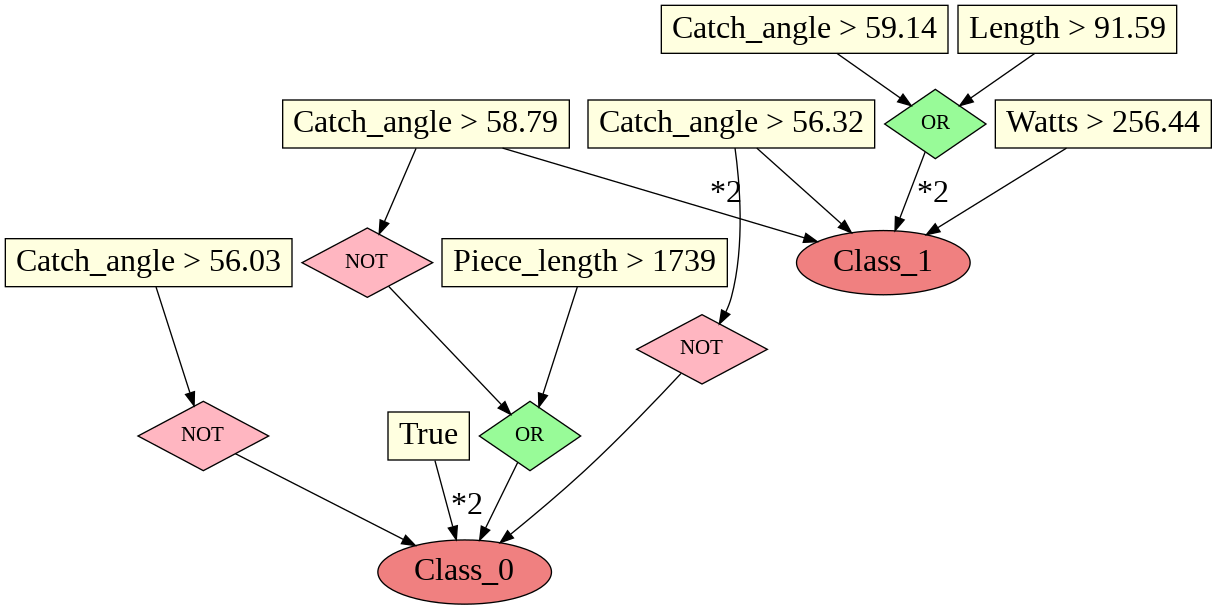

In [160]:
from IPython.display import Image
Image(filename='quickstart/example/viz.png')